# Table of Content

1. About the Data
2. Dataset and analysis
    - Data reading
    - Data cleaning
3. Models
    - Single Models
    - Ensemble Models
4. Conclusion

-----------------------------------------------------

# About the Data: Occupancy Rate of an Area

Occupancy Rates and Real Estate Investors
Occupancy rates are important to real estate investors because these numbers provide an indication of anticipated cash flows. A commercial real estate investor looking for a shopping center to buy is likely not interested in one that only has a 25% occupancy rate, meaning that tenants were leasing just 25% of the available storefronts and restaurant space in the mall.

This project allows to project whether an area is occupied and allows the projected result to be used for the reason stated above.

Cite:

Accurate occupancy detection of an office room from light, temperature, humidity and CO2 measurements using statistical learning models. Luis M. Candanedo, VÃ©ronique Feldheim. Energy and Buildings. Volume 112, 15 January 2016, Pages 28-39.

Attribute Information:

|Name|Description|
|--------------|-------------------------------------------------------------------------------------------|
|Date time | year-month-day hour:minute:second|
|Temperature |in Celsius|
|Relative Humidity| %|
|Light| in Lux|
|CO2| in ppm|
|Humidity Ratio| Derived quantity from temperature and relative humidity, in kgwater-vapor/kg-air|
|Occupancy| 0 or 1, 0 for not occupied, 1 for occupied status|

In [7]:
# Standard libraries
import numpy as np
import pandas as pd
import itertools
from sklearn.preprocessing import StandardScaler
from timeit import default_timer as timer

# Modelling
    # Ensemble modelling
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier
    # Logistic Regression model
from sklearn.linear_model import LogisticRegression
    # K-Nearest Neighbors model
from sklearn.neighbors import KNeighborsClassifier
    # Decision Tree model
from sklearn.tree import DecisionTreeClassifier
    # K-Means model
from sklearn.cluster import KMeans
    # SVM model
from sklearn.svm import SVC
from sklearn.svm import NuSVC
    # PCA model
from sklearn.decomposition import PCA
    # Random Forest model
from sklearn import tree
    # Naive Bayes
from sklearn.naive_bayes import GaussianNB

# Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

# Scoring
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [2]:
# Loading both train dataset and test dataset
data_train = pd.read_csv("./data/datatraining.csv")
data_test = pd.read_csv("./data/datatest.csv")

-------------------------------------------------------------------------------------------------------------------------------

# Dataset and Analysis

The following is a brief summary of the data for each column. 

## Data Reading

In [3]:
# Brief look of the dataset
data_train.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


C:\Users\User\Anaconda\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\User\Anaconda\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


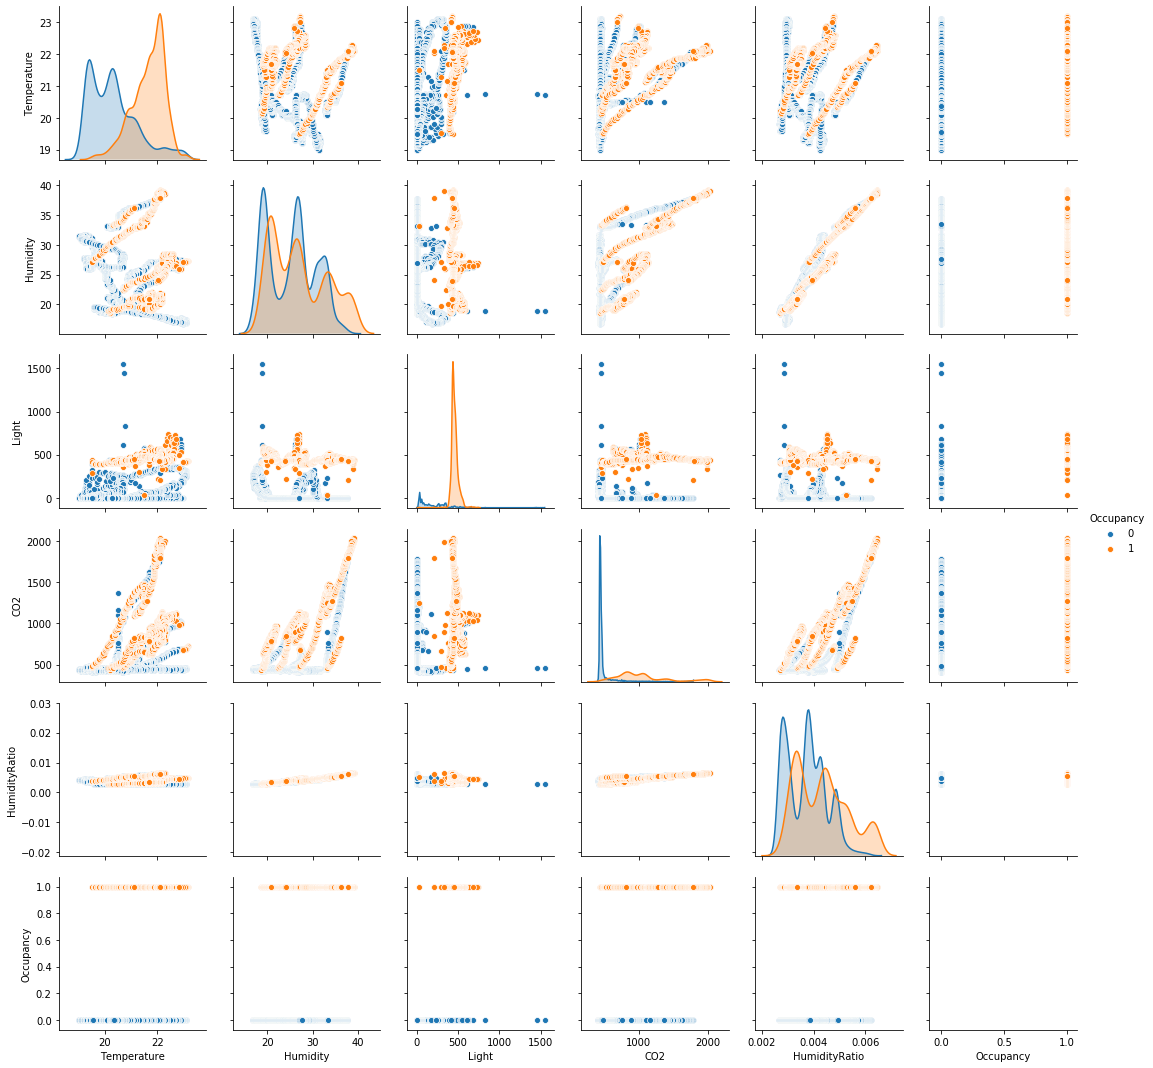

In [4]:
sns.pairplot(data_train, hue = 'Occupancy')

In [5]:
# Shape
print("=" * 100)
print("Number of data        : " + str(len(data_train)))
print("Number of features    : " + str(len(data_train.columns)))

# Data Types
print("=" * 100)
print("Data Types")
print("-" * 100)
print(data_train.dtypes)

# Minimum and Maximum within columns
print("=" * 100)
print("Domains and Intervals")
print("-" * 100)
for col in data_train.columns:
    if data_train[col].dtype == "float64":
        print("    " + col)
        print("        Min      : " + str(data_train[col].min()))
        print("        Max      : " + str(data_train[col].max()))
        print("        Mean     : " + str(data_train[col].mean()))
        print("        Std. Dev : " + str(data_train[col].std()))
    else:
        print("    " + col)
        print("        Min      : " + str(data_train[col].min()))
        print("        Max      : " + str(data_train[col].max()))

# Null count within columns        
print("=" * 100)
print("Nulls")
print("-" * 100)
print(data_train.isna().sum())
print("=" * 100)

Number of data        : 8143
Number of features    : 7
Data Types
----------------------------------------------------------------------------------------------------
date              object
Temperature      float64
Humidity         float64
Light            float64
CO2              float64
HumidityRatio    float64
Occupancy          int64
dtype: object
Domains and Intervals
----------------------------------------------------------------------------------------------------
    date
        Min      : 2015-02-04 17:51:00
        Max      : 2015-02-10 09:33:00
    Temperature
        Min      : 19.0
        Max      : 23.18
        Mean     : 20.61908364034621
        Std. Dev : 1.0169164411058422
    Humidity
        Min      : 16.745
        Max      : 39.1175
        Mean     : 25.731507286422527
        Std. Dev : 5.531210999582078
    Light
        Min      : 0.0
        Max      : 1546.33333333333
        Mean     : 119.51937451389756
        Std. Dev : 194.75580479862185
    CO2


Outliers


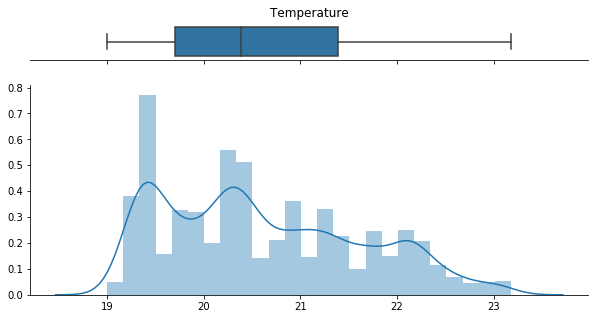

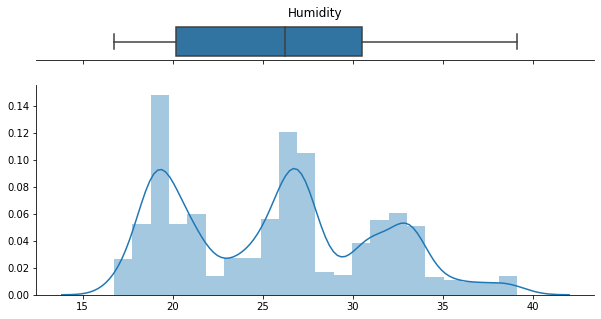

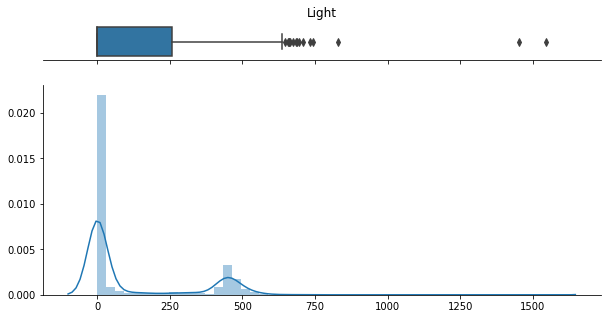

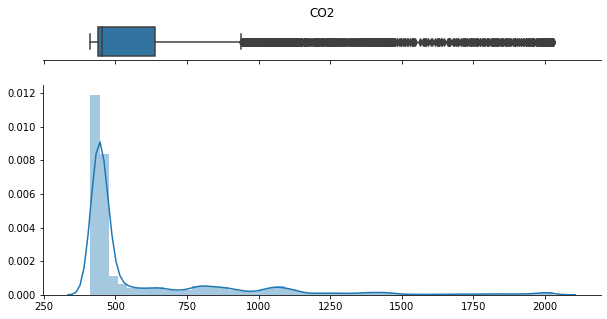

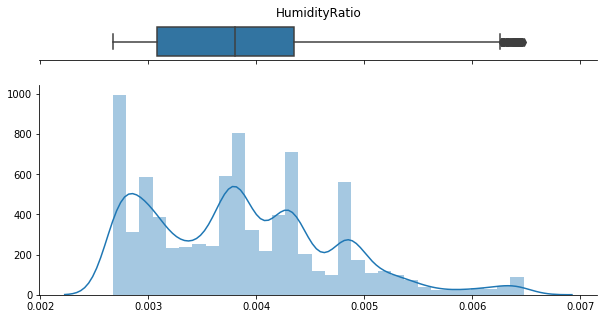

In [6]:
# Checking Outliers within the columns
print("Outliers")

num_cols = ["Temperature", "Humidity", "Light", "CO2", "HumidityRatio"]

for c in num_cols:
    fig, ax = plt.subplots(2,
                           figsize=(10, 5),
                           sharex=True,
                           gridspec_kw={'height_ratios': (0.15, 0.85)})

    ax_box = ax[0]
    ax_box = sns.boxplot(data_train[c], ax=ax_box)
    ax_box.set(title=c, yticks=[], xlabel='')
    sns.despine(ax=ax_box, left=True)

    ax_hist = ax[1]
    ax_hist = sns.distplot(data_train[c], ax=ax_hist)
    ax_hist.set(xlabel='')
    sns.despine(ax=ax_hist)

plt.show()

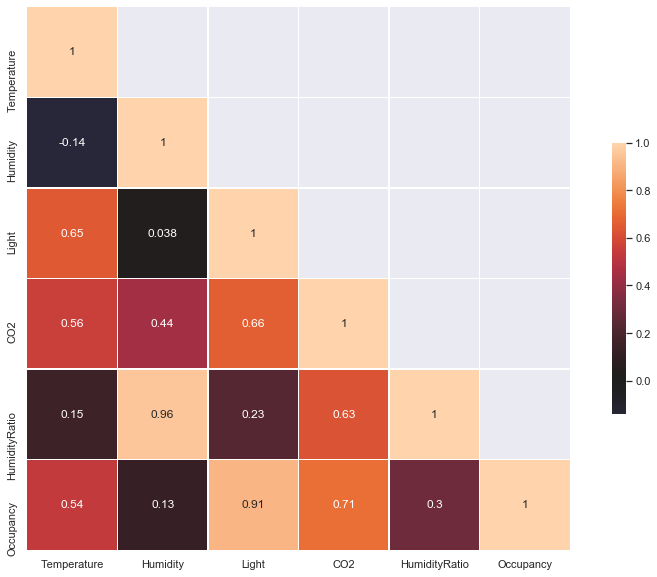

In [7]:
# Checking Data Correlations
data_corr = data_train.corr()

# Correlation Plots
sns.set(style = 'dark')
mask = np.zeros_like(data_corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
for i in range(data_corr.shape[0]):
    mask[i, i] = False
f, ax = plt.subplots(figsize=(15, 10))
cmap = sns.diverging_palette(220, 10, as_cmap = True)
sns.heatmap(data_corr, mask = mask, vmax = 1, center = 0, square = True, linewidths = 0.5, cbar_kws = {'shrink': 0.5}, annot = True)
plt.show()

------------------------------------------------------------------------------------------------------------------------------

## Data Cleaning

In [8]:
# Converting Date Time Column

data_train['date'] =  pd.to_datetime(data_train['date'])
data_test['date'] =  pd.to_datetime(data_test['date'])

As mentioned before, humidity ratio is calculated based on humidity and temperature. We can ignore this feature for now and possibly apply the same models to this particular feature. To ease the visualisation of the clustering, Temperature and Light have been selected as the features. 

In [9]:
feature1 = ["Temperature", "Light"]
predictor = "Occupancy"

In [10]:
# Setting predictors and target

X = data_train[feature1]
y = data_train[predictor]

In [11]:
# Checking for bias

y.value_counts()

0    6414
1    1729
Name: Occupancy, dtype: int64

In [6]:
print('Baseline Accuracy: %.2f' % (6414 / (6414 + 1729)))

Baseline Accuracy: 0.79


In [12]:
# Standardizing

# Remove!

scaler = StandardScaler()

X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)

X.head()

,Temperature,Light
0,2.518470,1.573763
1,2.488967,1.591735
2,2.488967,1.573763
3,2.488967,1.573763
4,2.439796,1.573763


-----------------------------------

In [13]:
def show_summary_report(actual, prediction):

    if isinstance(actual, pd.Series):
        actual = actual.values.astype(int)
    prediction = prediction.astype(float)
    prediction_int = prediction.astype(int)

    print('Accuracy : %.4f [TP + TN / N]    Best: 1, Worst: 0' %
          accuracy_score(actual, prediction_int))
    msg = '           Proportion of predicted labels that match the true labels.'
    print(msg)
    print('Precision: %.4f [TP / (TP + FP)] Best: 1, Worst: 0' %
          precision_score(actual, prediction_int))
    msg = '           Not to label a negative sample as positive.'
    print(msg)
    print('Recall   : %.4f [TP / (TP + FN)] Best: 1, Worst: 0' %
          recall_score(actual, prediction_int))
    msg = '           Find all the positive samples.'
    print(msg)
    print('ROC AUC  : %.4f                  Best: 1, Worst: < 0.5' %
          roc_auc_score(actual, prediction))
    print('-' * 80)

    # Confusion Matrix
    mat = confusion_matrix(actual, prediction_int)

    # Precision/Recall
    precision, recall, _ = precision_recall_curve(actual, prediction)

    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(actual, prediction)
    roc_auc = auc(fpr, tpr)

    # plot
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    fig.subplots_adjust(left=0.02, right=0.98, wspace=0.2)

    # Confusion Matrix
    sns.heatmap(mat.T, square=True, annot=True, fmt='d',
                cbar=False, cmap='Blues', ax=ax[0])

    ax[0].set_title('Confusion Matrix')
    ax[0].set_xlabel('True label')
    ax[0].set_ylabel('Predicted label')

    # Precision/Recall
    step_kwargs = {'step': 'post'}
    ax[1].step(recall, precision, color='b', alpha=0.2, where='post')
    ax[1].fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    ax[1].set_ylim([0.0, 1.0])
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('2-class Precision-Recall curve')

    # ROC
    ax[2].plot(fpr, tpr, color='darkorange', lw=2,
               label='ROC curve (AUC = %0.2f)' % roc_auc)
    ax[2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[2].set_xlim([0.0, 1.0])
    ax[2].set_ylim([0.0, 1.0])
    ax[2].set_xlabel('False Positive Rate')
    ax[2].set_ylabel('True Positive Rate')
    ax[2].set_title('Receiver Operating Characteristic')
    ax[2].legend(loc='lower right')

    plt.show()

----------

# Models

## Single Models

Having the target data available allows the usage of the supervised classification models. 

The binary classification will be done with 7 algorithms:
1. Decision Tree
2. KNN Classifier
3. Logistic Regression
4. Support Vector Machine
5. KMeans Classifier.
6. Naive Bayes
7. Random Forest

After classifying with each algorithm, the scores will be compared and the algorithm with a good robust score will be selected. The same process will be applied on the ensemble algorithms in the next section.

In [14]:
np.random.seed(0)
clf1 = DecisionTreeClassifier(criterion = 'entropy', max_depth = 2)
clf2 = KNeighborsClassifier(n_neighbors = 2)
clf3 = LogisticRegression(solver = 'lbfgs')
clf4 = SVC(kernel='linear', C=1000)
clf5 = KMeans(n_clusters = 2)
clf6 = GaussianNB()
clf7 = RandomForestClassifier()

----------------

The following is the accuracy of each model using the training dataset. The accuracy presented for both training and testing datasets will provide the following informations:

- Confusion Matrix
    - TP: True Positives
    - FP: False Positives
    - TN: True Negatives
    - FN: False Negatives



N: Number of samples

Decision Tree
--------------------------------------------------------------------------------
Accuracy : 0.9878 [TP + TN / N]         Best: 1, Worst: 0
           Proportion of predicted labels that match the true labels.
Precision: 0.9503 [TP / (TP + FP)] Best: 1, Worst: 0
           Not to label a negative sample as positive.
Recall   : 0.9948 [TP / (TP + FN)] Best: 1, Worst: 0
           Find all the positive samples.
ROC AUC  : 0.9904                  Best: 1, Worst: < 0.5
--------------------------------------------------------------------------------


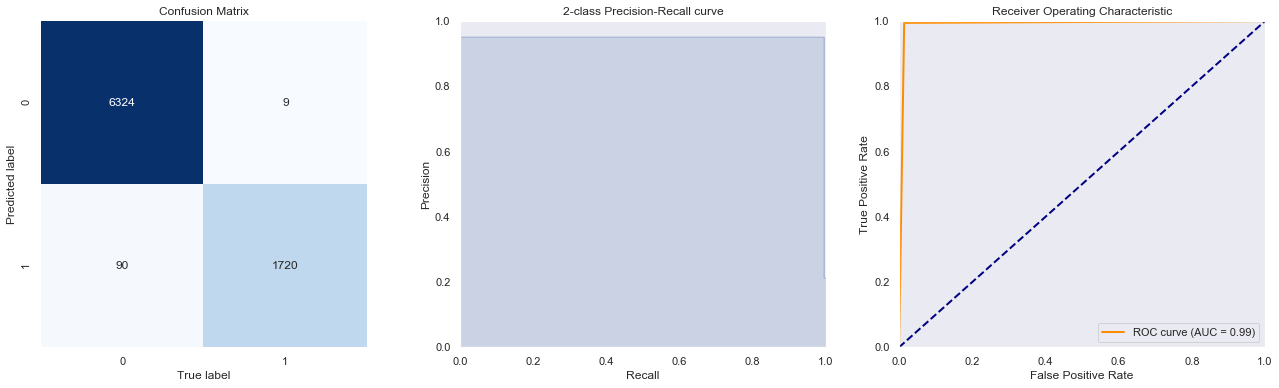

Time taken:  0.9285  second(s)
K-NN
--------------------------------------------------------------------------------
Accuracy : 0.9950 [TP + TN / N]         Best: 1, Worst: 0
           Proportion of predicted labels that match the true labels.
Precision: 0.9976 [TP / (TP + FP)] Best: 1, Worst: 0
           Not to label a negative sample as positive.
Recall   : 0.9786 [TP / (TP + FN)] Best: 1, Worst: 0
           Find all the positive samples.
ROC AUC  : 0.9890                  Best: 1, Worst: < 0.5
--------------------------------------------------------------------------------


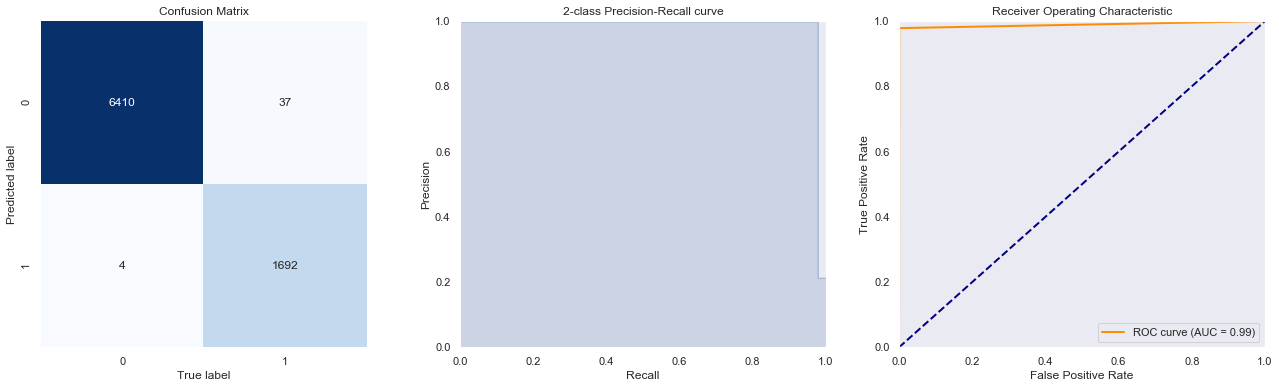

Time taken:  1.2087  second(s)
Logistic Regression
--------------------------------------------------------------------------------
Accuracy : 0.9880 [TP + TN / N]         Best: 1, Worst: 0
           Proportion of predicted labels that match the true labels.
Precision: 0.9498 [TP / (TP + FP)] Best: 1, Worst: 0
           Not to label a negative sample as positive.
Recall   : 0.9960 [TP / (TP + FN)] Best: 1, Worst: 0
           Find all the positive samples.
ROC AUC  : 0.9909                  Best: 1, Worst: < 0.5
--------------------------------------------------------------------------------


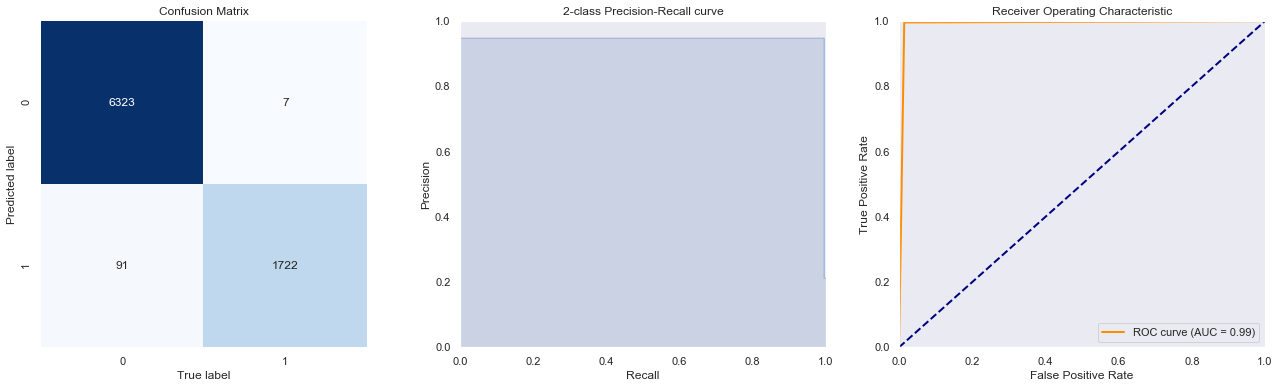

Time taken:  0.9879  second(s)
Support Vector Machine
--------------------------------------------------------------------------------
Accuracy : 0.9880 [TP + TN / N]         Best: 1, Worst: 0
           Proportion of predicted labels that match the true labels.
Precision: 0.9503 [TP / (TP + FP)] Best: 1, Worst: 0
           Not to label a negative sample as positive.
Recall   : 0.9954 [TP / (TP + FN)] Best: 1, Worst: 0
           Find all the positive samples.
ROC AUC  : 0.9907                  Best: 1, Worst: < 0.5
--------------------------------------------------------------------------------


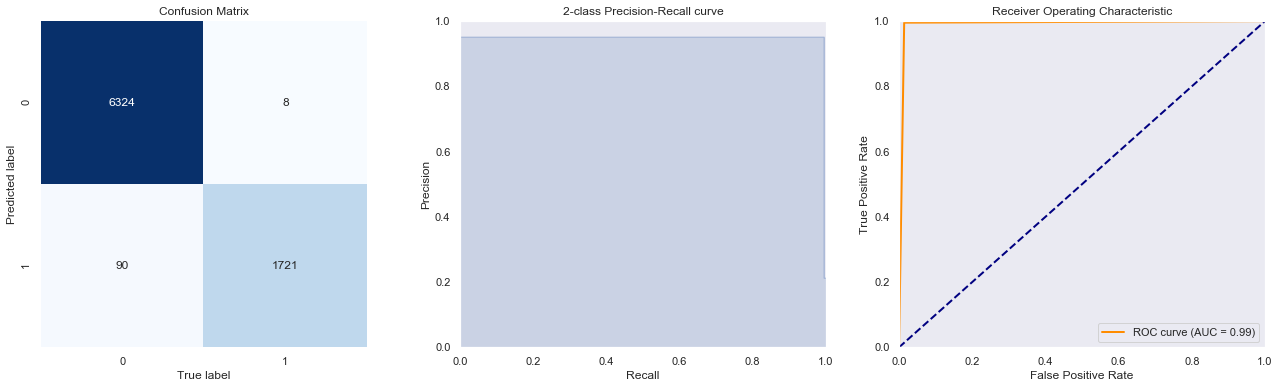

Time taken:  4.2581  second(s)
K-Means
--------------------------------------------------------------------------------
Accuracy : 0.9419 [TP + TN / N]         Best: 1, Worst: 0
           Proportion of predicted labels that match the true labels.
Precision: 0.7899 [TP / (TP + FP)] Best: 1, Worst: 0
           Not to label a negative sample as positive.
Recall   : 0.9896 [TP / (TP + FN)] Best: 1, Worst: 0
           Find all the positive samples.
ROC AUC  : 0.9593                  Best: 1, Worst: < 0.5
--------------------------------------------------------------------------------


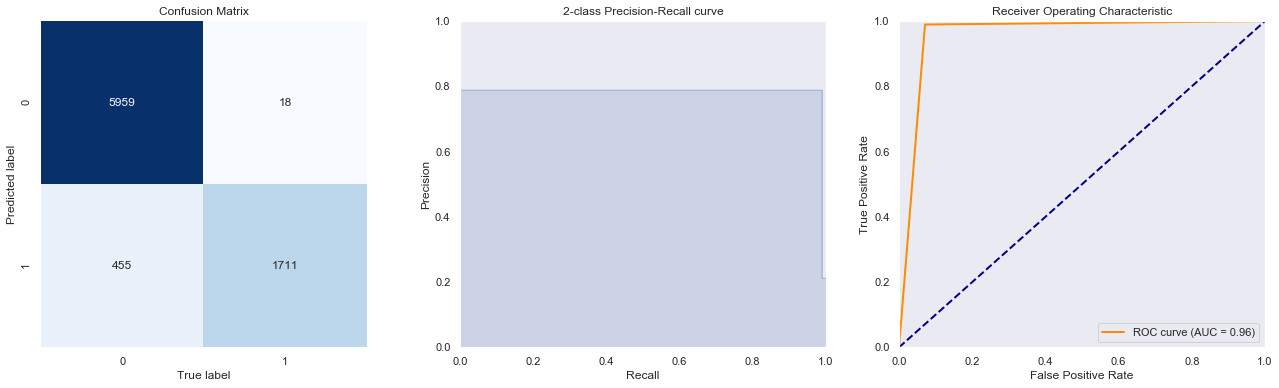

Time taken:  0.9148  second(s)
Naive Bayes
--------------------------------------------------------------------------------
Accuracy : 0.9732 [TP + TN / N]         Best: 1, Worst: 0
           Proportion of predicted labels that match the true labels.
Precision: 0.8900 [TP / (TP + FP)] Best: 1, Worst: 0
           Not to label a negative sample as positive.
Recall   : 0.9971 [TP / (TP + FN)] Best: 1, Worst: 0
           Find all the positive samples.
ROC AUC  : 0.9819                  Best: 1, Worst: < 0.5
--------------------------------------------------------------------------------


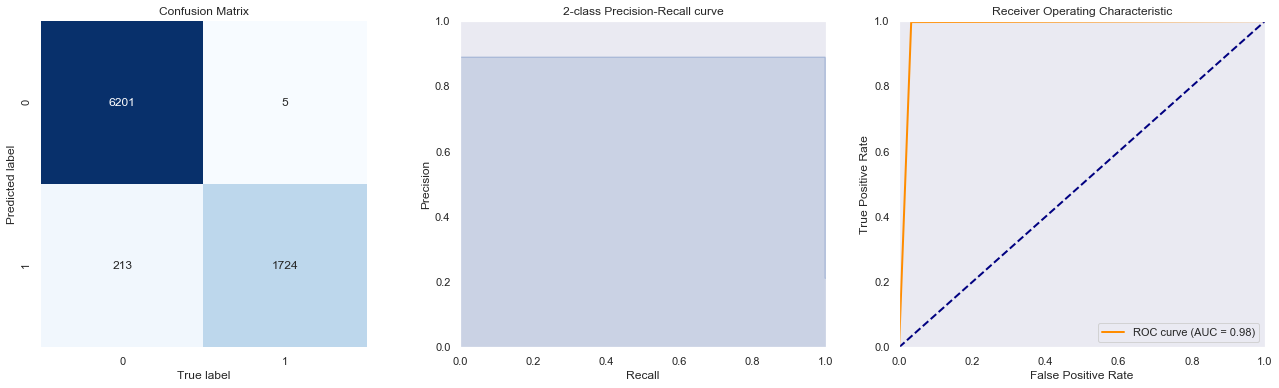

Time taken:  0.8651  second(s)
Random Forest
--------------------------------------------------------------------------------
Accuracy : 0.9973 [TP + TN / N]         Best: 1, Worst: 0
           Proportion of predicted labels that match the true labels.
Precision: 0.9942 [TP / (TP + FP)] Best: 1, Worst: 0
           Not to label a negative sample as positive.
Recall   : 0.9931 [TP / (TP + FN)] Best: 1, Worst: 0
           Find all the positive samples.
ROC AUC  : 0.9958                  Best: 1, Worst: < 0.5
--------------------------------------------------------------------------------


C:\Users\User\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


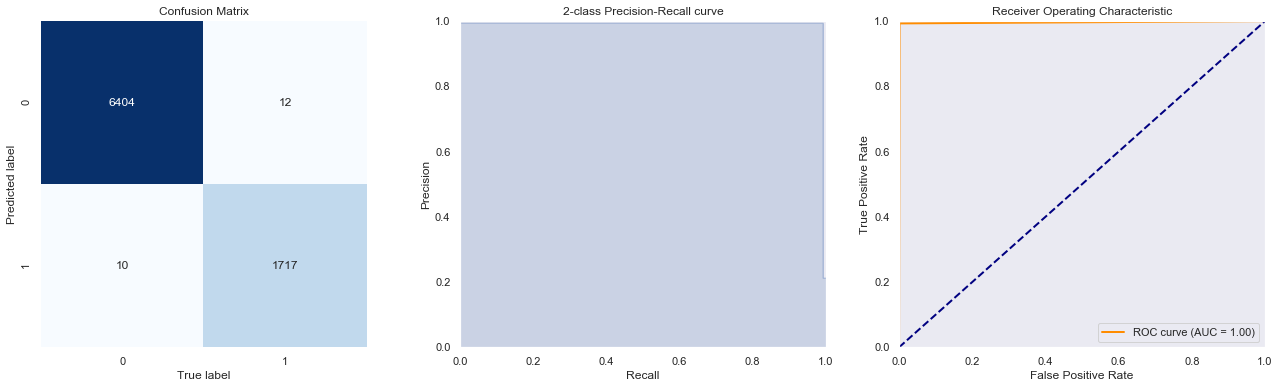

Time taken:  1.105  second(s)


In [15]:
label = ['Decision Tree', 'K-NN', 'Logistic Regression', 'Support Vector Machine', 'K-Means', 'Naive Bayes', 'Random Forest']
clf_list = [clf1, clf2, clf3, clf4, clf5, clf6, clf7]

for clf, label in zip(clf_list, label):
    start = timer()
    print("=" * 80)
    print(label)
    print("-" * 80)
    clf.fit(X, y)
    y_pred = clf.predict(X)
    show_summary_report(y, y_pred)
    end = timer()
    print("Time taken: ", round(end-start, 4), " second(s)")
    print("=" * 80)

As shown in the summary above, all the algorithms have a high accuracy. This doesn't help us determine whether the scores are robust or not nor overfitting within each algorithm. The following section will show whether algorithms have overfitted and the next one will show how robust each algorithm is.

----------------------------

The following is the accuracy of each model using the testing dataset. 

In [16]:
# Test Data
X_test = data_test[feature1]
y_test = data_test[predictor]

Decision Tree
--------------------------------------------------------------------------------
Accuracy : 0.9707 [TP + TN / N]         Best: 1, Worst: 0
           Proportion of predicted labels that match the true labels.
Precision: 0.9257 [TP / (TP + FP)] Best: 1, Worst: 0
           Not to label a negative sample as positive.
Recall   : 1.0000 [TP / (TP + FN)] Best: 1, Worst: 0
           Find all the positive samples.
ROC AUC  : 0.9770                  Best: 1, Worst: < 0.5
--------------------------------------------------------------------------------


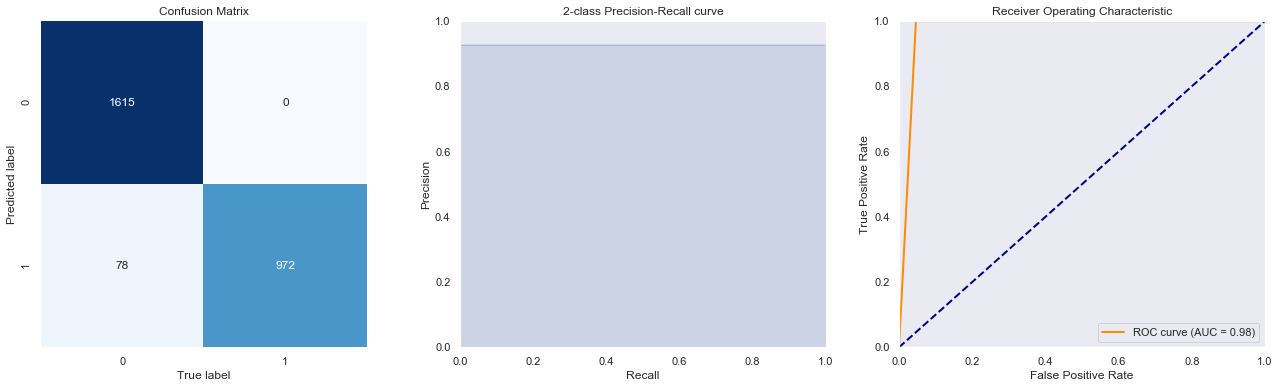

Time taken:  1.0488  second(s)
K-NN
--------------------------------------------------------------------------------
Accuracy : 0.6353 [TP + TN / N]         Best: 1, Worst: 0
           Proportion of predicted labels that match the true labels.
Precision: 0.0000 [TP / (TP + FP)] Best: 1, Worst: 0
           Not to label a negative sample as positive.
Recall   : 0.0000 [TP / (TP + FN)] Best: 1, Worst: 0
           Find all the positive samples.
ROC AUC  : 0.5000                  Best: 1, Worst: < 0.5
--------------------------------------------------------------------------------


C:\Users\User\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


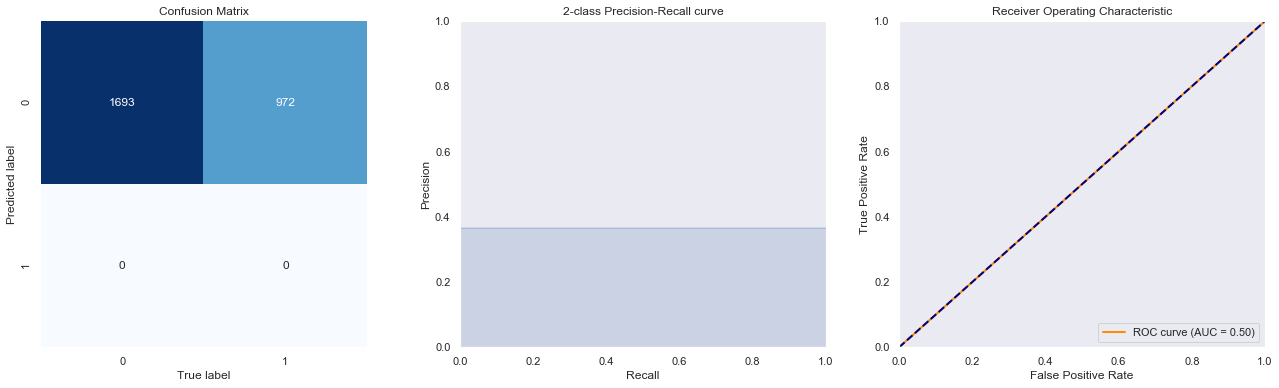

Time taken:  1.1331  second(s)
Logistic Regression
--------------------------------------------------------------------------------
Accuracy : 0.9707 [TP + TN / N]         Best: 1, Worst: 0
           Proportion of predicted labels that match the true labels.
Precision: 0.9257 [TP / (TP + FP)] Best: 1, Worst: 0
           Not to label a negative sample as positive.
Recall   : 1.0000 [TP / (TP + FN)] Best: 1, Worst: 0
           Find all the positive samples.
ROC AUC  : 0.9770                  Best: 1, Worst: < 0.5
--------------------------------------------------------------------------------


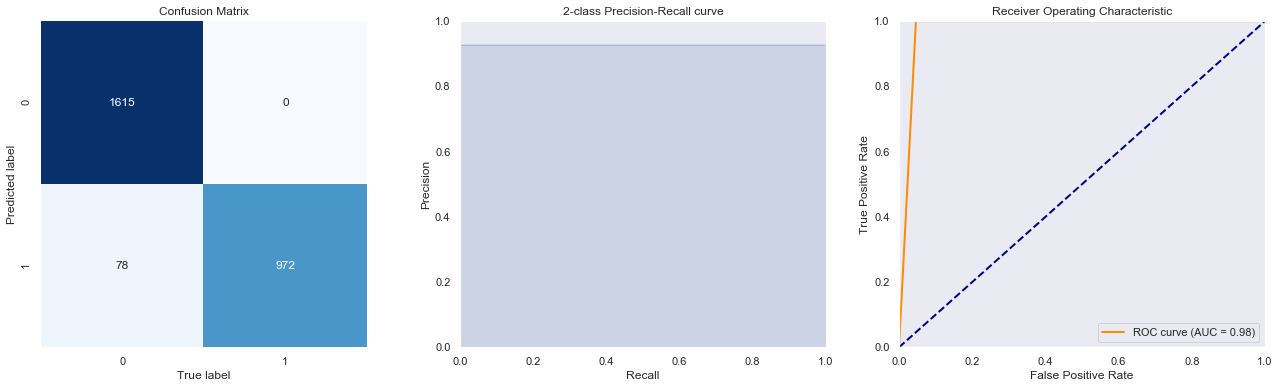

Time taken:  0.9868  second(s)
Support Vector Machine
--------------------------------------------------------------------------------
Accuracy : 0.9707 [TP + TN / N]         Best: 1, Worst: 0
           Proportion of predicted labels that match the true labels.
Precision: 0.9257 [TP / (TP + FP)] Best: 1, Worst: 0
           Not to label a negative sample as positive.
Recall   : 1.0000 [TP / (TP + FN)] Best: 1, Worst: 0
           Find all the positive samples.
ROC AUC  : 0.9770                  Best: 1, Worst: < 0.5
--------------------------------------------------------------------------------


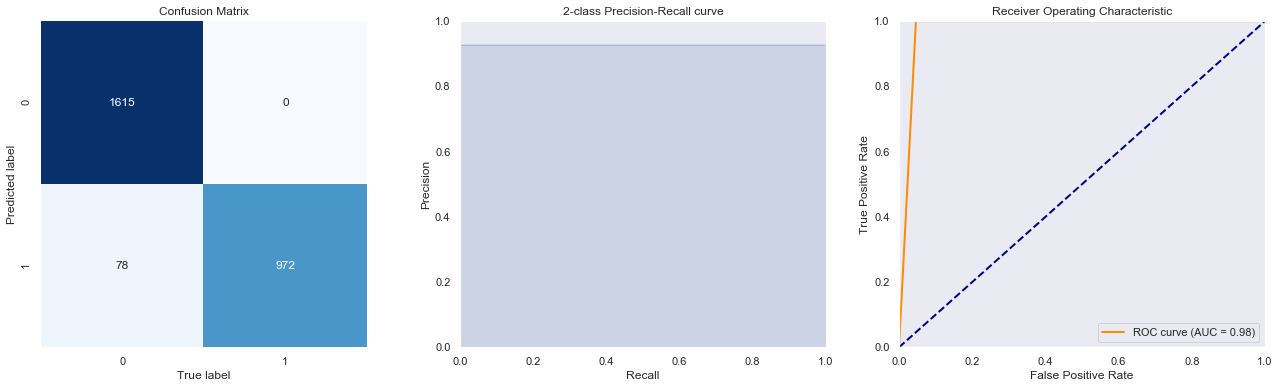

Time taken:  4.2577  second(s)
K-Means
--------------------------------------------------------------------------------
Accuracy : 0.6353 [TP + TN / N]         Best: 1, Worst: 0
           Proportion of predicted labels that match the true labels.
Precision: 0.0000 [TP / (TP + FP)] Best: 1, Worst: 0
           Not to label a negative sample as positive.
Recall   : 0.0000 [TP / (TP + FN)] Best: 1, Worst: 0
           Find all the positive samples.
ROC AUC  : 0.5000                  Best: 1, Worst: < 0.5
--------------------------------------------------------------------------------


C:\Users\User\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


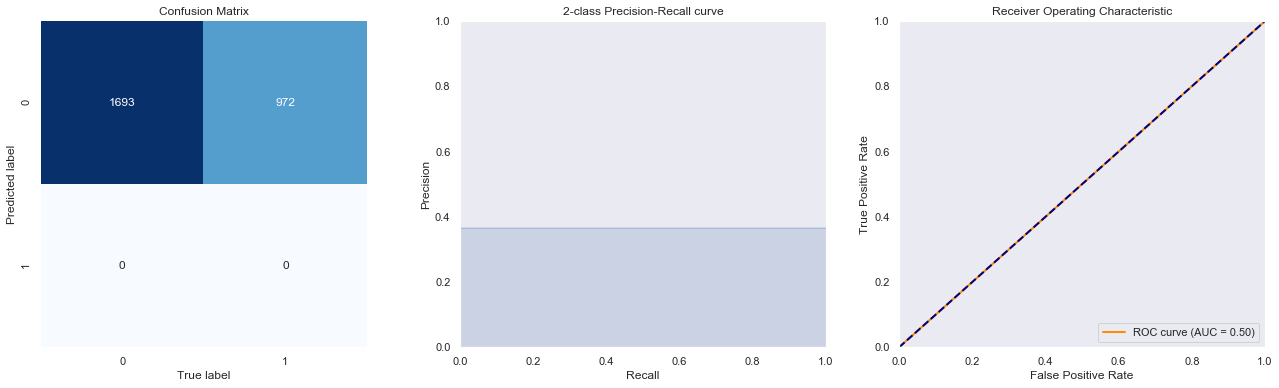

Time taken:  1.0915  second(s)
Naive Bayes
--------------------------------------------------------------------------------
Accuracy : 0.6353 [TP + TN / N]         Best: 1, Worst: 0
           Proportion of predicted labels that match the true labels.
Precision: 0.0000 [TP / (TP + FP)] Best: 1, Worst: 0
           Not to label a negative sample as positive.
Recall   : 0.0000 [TP / (TP + FN)] Best: 1, Worst: 0
           Find all the positive samples.
ROC AUC  : 0.5000                  Best: 1, Worst: < 0.5
--------------------------------------------------------------------------------


C:\Users\User\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


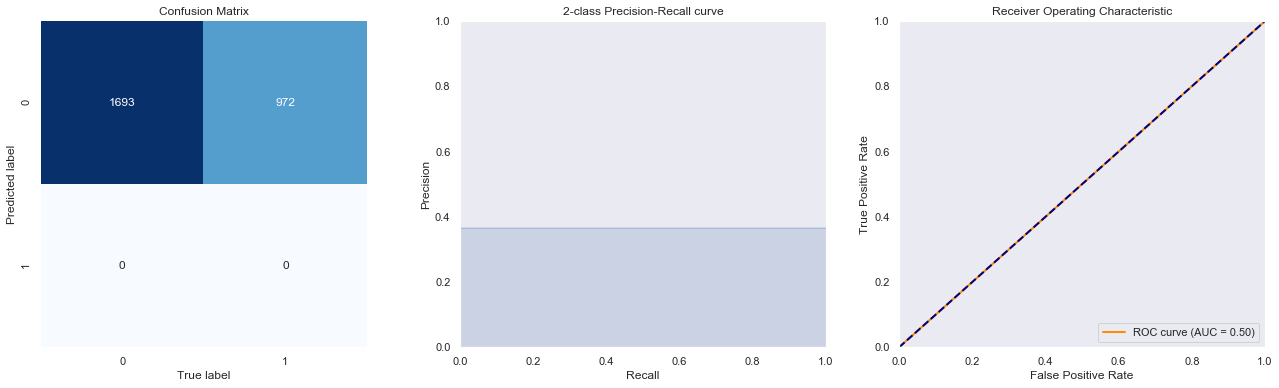

Time taken:  0.9572  second(s)
Random Forest
--------------------------------------------------------------------------------
Accuracy : 0.6353 [TP + TN / N]         Best: 1, Worst: 0
           Proportion of predicted labels that match the true labels.
Precision: 0.0000 [TP / (TP + FP)] Best: 1, Worst: 0
           Not to label a negative sample as positive.
Recall   : 0.0000 [TP / (TP + FN)] Best: 1, Worst: 0
           Find all the positive samples.
ROC AUC  : 0.5000                  Best: 1, Worst: < 0.5
--------------------------------------------------------------------------------


C:\Users\User\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


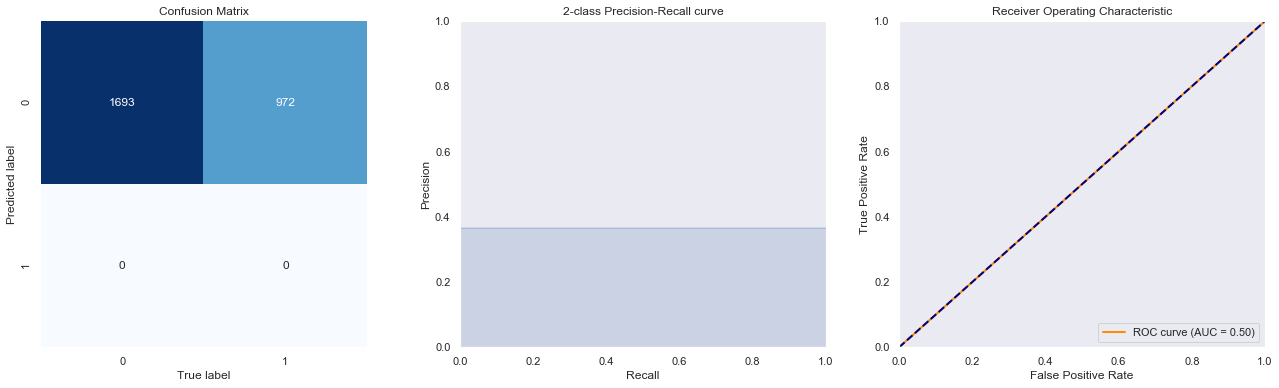

Time taken:  0.8923  second(s)


In [17]:
label = ['Decision Tree', 'K-NN', 'Logistic Regression', 'Support Vector Machine', 'K-Means', 'Naive Bayes', 'Random Forest']
clf_list = [clf1, clf2, clf3, clf4, clf5, clf6, clf7]

for clf, label in zip(clf_list, label):
    start = timer()
    print("=" * 80)
    print(label)
    print("-" * 80)
    clf.fit(X, y)
    y_pred = clf.predict(X_test)
    show_summary_report(y_test, y_pred)
    end = timer()
    print("Time taken: ", round(end-start, 4), " second(s)")
    print("=" * 80)

The following are the results of each of the algorithms. X-axis is the Temperature and Y-axis is the Light

Text(0.5, 1.0, 'Decision Tree')

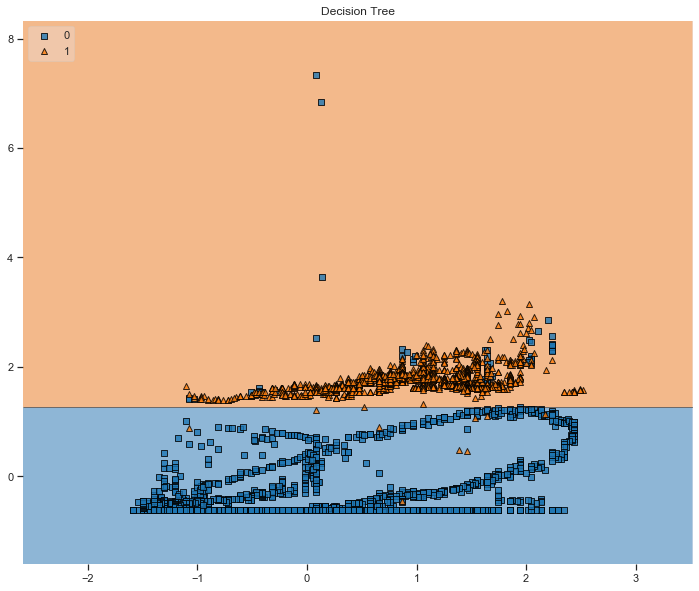

In [18]:
fig = plt.figure(figsize = (12, 10))

fig = plot_decision_regions(X = np.array(X[['Temperature', 'Light']]), y = np.array(y), clf = clf1, legend = 2)
plt.title('Decision Tree')

Text(0.5, 1.0, 'KNN Classifier')

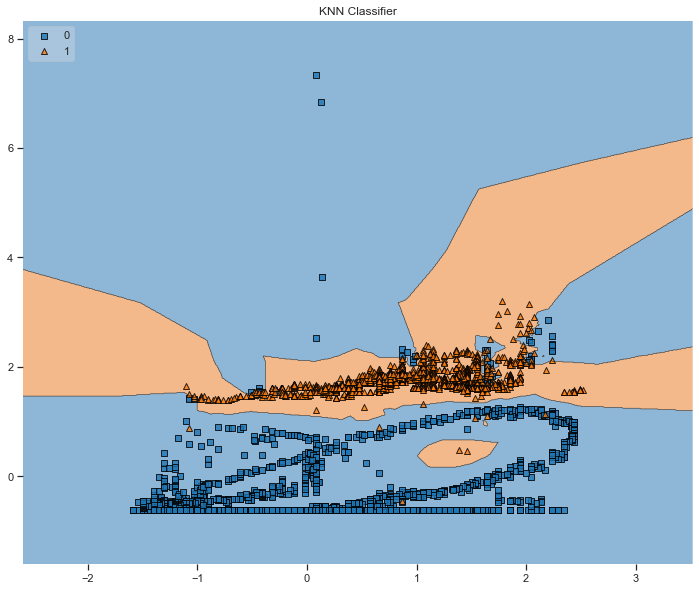

In [19]:
fig = plt.figure(figsize = (12, 10))

fig = plot_decision_regions(X = np.array(X[['Temperature', 'Light']]), y = np.array(y), clf = clf2, legend = 2)
plt.title('KNN Classifier')

Text(0.5, 1.0, 'Logistic Regression')

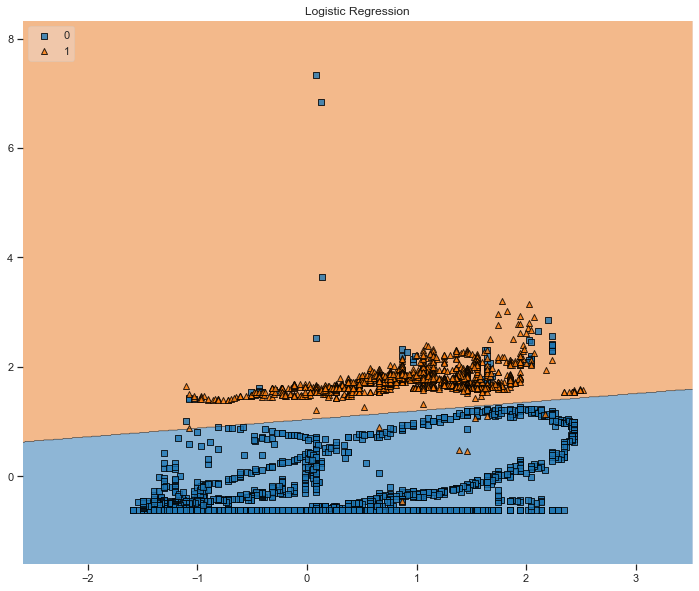

In [20]:
fig = plt.figure(figsize = (12, 10))

fig = plot_decision_regions(X = np.array(X[['Temperature', 'Light']]), y = np.array(y), clf = clf3, legend = 2)
plt.title('Logistic Regression')

Text(0.5, 1.0, 'Support Vector Machine')

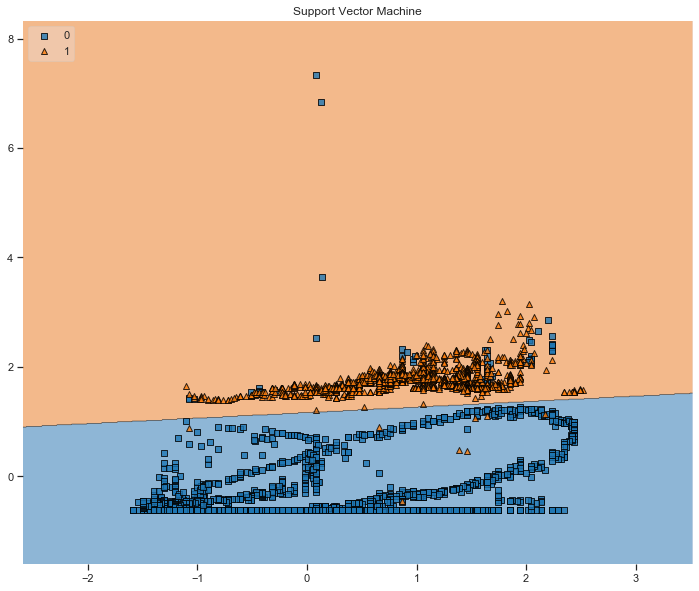

In [21]:
fig = plt.figure(figsize = (12, 10))

fig = plot_decision_regions(X = np.array(X[['Temperature', 'Light']]), y = np.array(y), clf = clf4, legend = 2)
plt.title('Support Vector Machine')

Text(0.5, 1.0, 'KMeans Classifier')

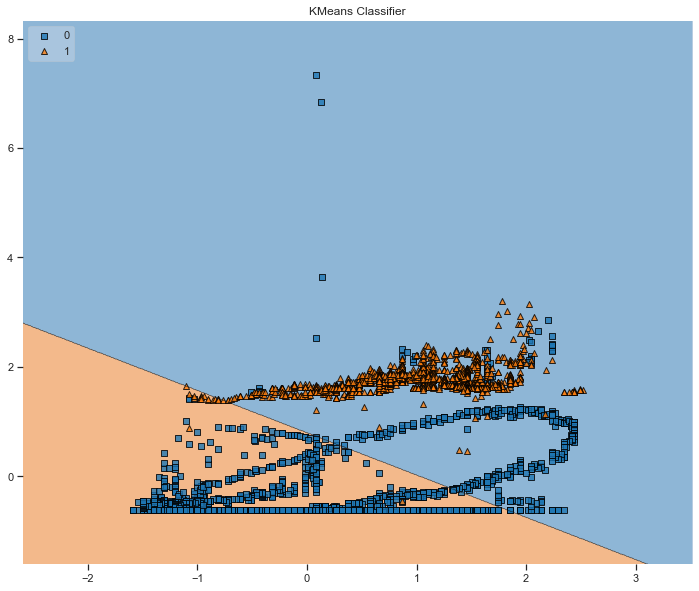

In [22]:
fig = plt.figure(figsize = (12, 10))

fig = plot_decision_regions(X = np.array(X[['Temperature', 'Light']]), y = np.array(y), clf = clf5, legend = 2)
plt.title('KMeans Classifier')

Text(0.5, 1.0, 'Naive Bayes')

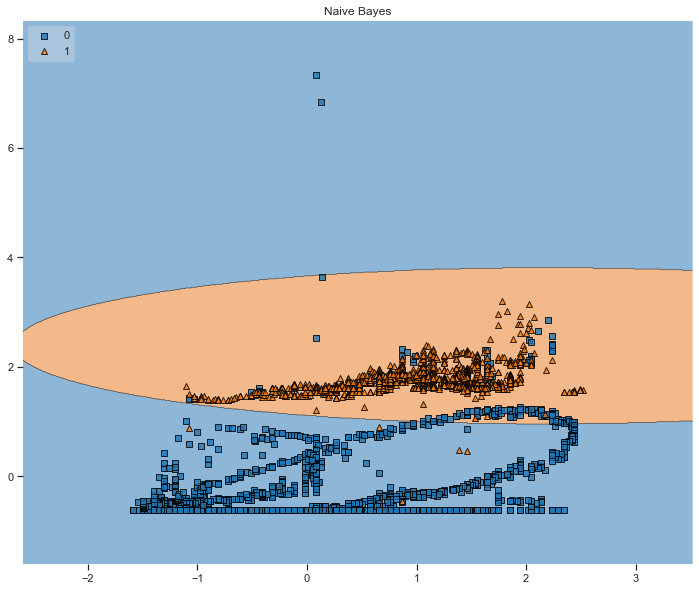

In [23]:
fig = plt.figure(figsize = (12, 10))

fig = plot_decision_regions(X = np.array(X[['Temperature', 'Light']]), y = np.array(y), clf = clf6, legend = 2)
plt.title('Naive Bayes')

Text(0.5, 1.0, 'Random Forest')

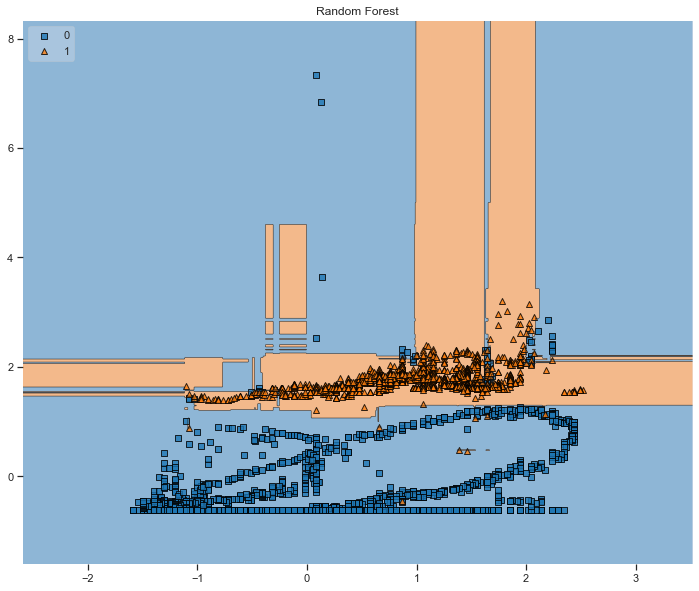

In [24]:
fig = plt.figure(figsize = (12, 10))

fig = plot_decision_regions(X = np.array(X[['Temperature', 'Light']]), y = np.array(y), clf = clf7, legend = 2)
plt.title('Random Forest')

-------

From the accuracy shown below, we can determine that all of the models are robust as none shows any significant differences in the training score and testing score.

In [25]:
# Train Accuracy

label = ['Decision Tree', 'K-NN', 'Logistic Regression', 'Support Vector Machine', 'K-Means', 'Naive Bayes', 'Random Forest']
clf_list = [clf1, clf2, clf3, clf4, clf5, clf6, clf7]

for clf, label in zip(clf_list, label):
    start = timer()
    scores = cross_val_score(clf, X, y, cv = 5, scoring = 'accuracy')
    mean_score = scores
    print('Accuracy: %.2f (+/- %.2f) [%s]' % (scores.mean(), scores.std(), label))
    end = timer()
    print("Time taken: ", round(end-start, 4), " second(s)")
    print('-' * 80)

Accuracy: 0.98 (+/- 0.02) [Decision Tree]
Time taken:  0.042  second(s)
--------------------------------------------------------------------------------
Accuracy: 0.93 (+/- 0.06) [K-NN]
Time taken:  0.3941  second(s)
--------------------------------------------------------------------------------
Accuracy: 0.98 (+/- 0.02) [Logistic Regression]
Time taken:  0.0789  second(s)
--------------------------------------------------------------------------------
Accuracy: 0.98 (+/- 0.02) [Support Vector Machine]
Time taken:  14.2468  second(s)
--------------------------------------------------------------------------------
Accuracy: 0.81 (+/- 0.32) [K-Means]
Time taken:  0.2252  second(s)
--------------------------------------------------------------------------------
Accuracy: 0.97 (+/- 0.04) [Naive Bayes]
Time taken:  0.0348  second(s)
--------------------------------------------------------------------------------
Accuracy: 0.94 (+/- 0.06) [Random Forest]
Time taken:  0.1655  second(s)
-----

In [26]:
# Test Accuracy

label = ['Decision Tree', 'K-NN', 'Logistic Regression', 'Support Vector Machine', 'K-Means', 'Naive Bayes', 'Random Forest']
clf_list = [clf1, clf2, clf3, clf4, clf5, clf6, clf7]

for clf, label in zip(clf_list, label):
    start = timer()
    scores = cross_val_score(clf, X_test, y_test, cv = 5, scoring = 'accuracy')
    mean_score = scores
    print('Accuracy: %.2f (+/- %.2f) [%s]' % (scores.mean(), scores.std(), label))
    end = timer()
    print("Time taken: ", round(end-start, 4), " second(s)")
    print('-' * 80)

Accuracy: 0.97 (+/- 0.03) [Decision Tree]
Time taken:  0.0325  second(s)
--------------------------------------------------------------------------------
Accuracy: 0.94 (+/- 0.03) [K-NN]
Time taken:  0.1365  second(s)
--------------------------------------------------------------------------------
Accuracy: 0.98 (+/- 0.02) [Logistic Regression]
Time taken:  0.1052  second(s)
--------------------------------------------------------------------------------
Accuracy: 0.98 (+/- 0.02) [Support Vector Machine]
Time taken:  44.8532  second(s)
--------------------------------------------------------------------------------
Accuracy: 0.98 (+/- 0.02) [K-Means]
Time taken:  0.1074  second(s)
--------------------------------------------------------------------------------
Accuracy: 0.97 (+/- 0.03) [Naive Bayes]
Time taken:  0.0268  second(s)
--------------------------------------------------------------------------------
Accuracy: 0.96 (+/- 0.02) [Random Forest]
Time taken:  0.2524  second(s)
----

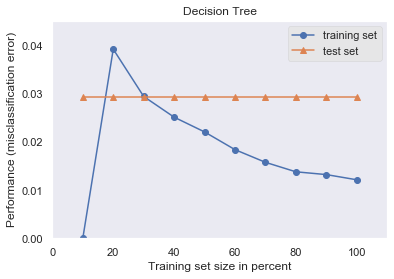

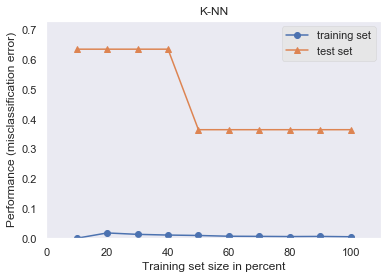

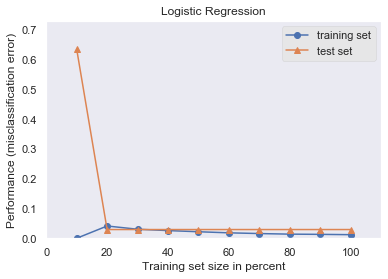

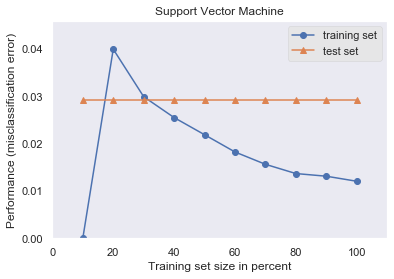

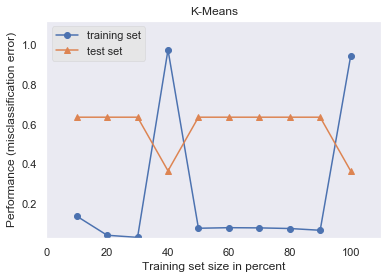

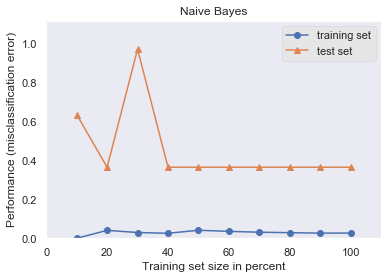

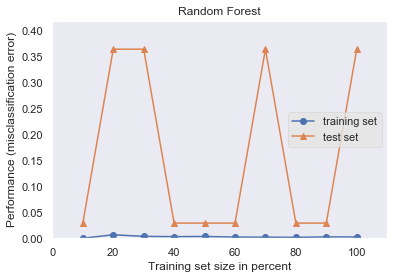

In [27]:
label = ['Decision Tree', 'K-NN', 'Logistic Regression', 'Support Vector Machine', 'K-Means', 'Naive Bayes', 'Random Forest']
clf_list = [clf1, clf2, clf3, clf4, clf5, clf6, clf7]

for clf, label in zip(clf_list, label):
    plt.figure()
    plt.title(label)
    plot_learning_curves(X, y, X_test, y_test, clf, print_model = False, style = 'ggplot')

plt.show()

----------------------

## Ensemble models

Algorithms alone may not give the best result, but you may achieve better result when all the algorithms are combined. The models involved are bagging, boosting and stacking. The following is bagging classifier for each algorithm that was used in the previous section.

### Bagging

Bagging stands for bootstrap aggregation. One way to reduce the variance of an estimate is to average together multiple estimates.

In [28]:
bagging1 = BaggingClassifier(
    base_estimator = clf1,
    n_estimators = 10,
    max_samples = 0.8,
    max_features = 0.8)
bagging2 = BaggingClassifier(
    base_estimator = clf2,
    n_estimators = 10,
    max_samples = 0.8,
    max_features = 0.8)
bagging3 = BaggingClassifier(
    base_estimator = clf3,
    n_estimators = 10,
    max_samples = 0.8,
    max_features = 0.8)
bagging4 = BaggingClassifier(
    base_estimator = clf4,
    n_estimators = 10,
    max_samples = 0.8,
    max_features = 0.8)
bagging5 = BaggingClassifier(
    base_estimator = clf5,
    n_estimators = 10,
    max_samples = 0.8,
    max_features = 0.8)
bagging6 = BaggingClassifier(
    base_estimator = clf6,
    n_estimators = 10,
    max_samples = 0.8,
    max_features = 0.8)
bagging7 = BaggingClassifier(
    base_estimator = clf7,
    n_estimators = 10,
    max_samples = 0.8,
    max_features = 0.8)

In [29]:
label = ['Decision Tree', 'K-NN', 'Logistic Regression', 'Support Vector Machine', 'K-Means', 'Naive Bayes', 'Random Forest']
bag_clf_list = [bagging1, bagging2, bagging3, bagging4, bagging5, bagging6, bagging7]

# Train Accuracy

for clf, label in zip(bag_clf_list, label):
    start= timer()
    scores = cross_val_score(clf, X, y, cv = 5, scoring = 'accuracy')
    mean_score = scores
    print('Accuracy: %.2f (+/- %.2f) [%s]' % (scores.mean(), scores.std(), label))
    end = timer()
    print("Time taken: ", round(end-start, 4), " second(s)")
    print('-' * 80)

In [ ]:
label = ['Decision Tree', 'K-NN', 'Logistic Regression', 'Support Vector Machine', 'K-Means', 'Naive Bayes', 'Random Forest']
bag_clf_list = [bagging1, bagging2, bagging3, bagging4, bagging5, bagging6, bagging7]

for clf, label in zip(bag_clf_list, label):
    plt.figure()
    plt.title(label)
    plot_learning_curves(X, y, X_test, y_test, clf, print_model = False, style = 'ggplot')

plt.show()

The accuracy shown was done under 10 estimators and this may not be the right number of estimators. The following will show the accuracy from 1 estimator to 100 estimators for each classifier. 

In [ ]:
# Ensemble Size
num_est = np.linspace(1, 100, 20, dtype = np.int8)

np.random.seed(2534)

label = ['Decision Tree', 'K-NN', 'Logistic Regression', 'Support Vector Machine', 'K-Means', 'Naive Bayes', 'Random Forest']
bag_clf_list = [bagging1, bagging2, bagging3, bagging4, bagging5, bagging6, bagging7]

for clf, label in zip(clf_list, label):
    bg_clf_cv_mean = []
    bg_clf_cv_std = []
    for n_est in num_est:    
        bg_clf = BaggingClassifier(
            base_estimator = clf1,
            n_estimators = n_est,
            max_samples = 0.8,
            max_features = 0.8)
        scores = cross_val_score(bg_clf, X, y, cv = 3, scoring = 'accuracy')
        bg_clf_cv_mean.append(scores.mean())
        bg_clf_cv_std.append(scores.std())

    plt.figure()
    (_, caps, _) = plt.errorbar(
        num_est,
        bg_clf_cv_mean,
        yerr = bg_clf_cv_std,
        c = 'blue',
        fmt = '-o',
        capsize = 5)

    for cap in caps:
        cap.set_markeredgewidth(1)                                                                                                                                

    plt.title(label + ' Bagging Tree Ensemble')
    plt.ylabel('Accuracy')
    plt.xlabel('Ensemble Size')

plt.show()

### Boosting

Boosting refers to a family of algorithms that are able to convert weak learners to strong learners. 

From in the single algorithm section, we learned that Naive Bayes is the weakest learner among the 7 algorithms used and Decision Tree is the best among the 6. Perhaps it is worthed to see the growth of the two algorithms mentioned under different number of estimators. 

In [28]:
start = timer()
clf_strong = DecisionTreeClassifier(criterion = 'entropy', max_depth = 1)
clf_weak = GaussianNB()
end = timer()
print("Time taken: ", round(end-start, 4), " second(s)")

Time taken:  0.0001  second(s)


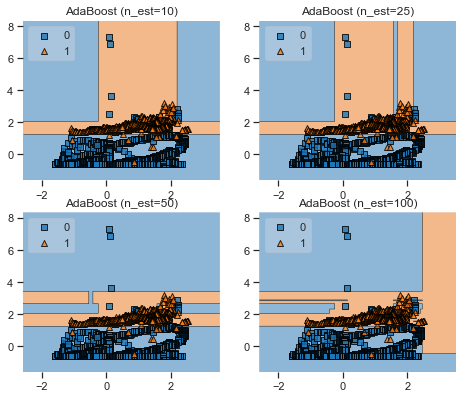

Time taken:  23.6547  second(s)


In [29]:
start = timer()

num_est = [10, 25, 50, 100]
label = ['AdaBoost (n_est=%d)' % i for i in num_est]

fig = plt.figure(figsize = (12, 10))
gs = gridspec.GridSpec(3, 3)
grid = itertools.product([0, 1], repeat = 2)

for n_est, label, grd in zip(num_est, label, grid):     
    boosting = AdaBoostClassifier(base_estimator = clf_strong, n_estimators = n_est)   
    boosting.fit(X[['Temperature', 'Light']], y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X = np.array(X[['Temperature', 'Light']]), y = np.array(y), clf = boosting, legend = 2)
    plt.title(label)

plt.show()

end = timer()

print("Time taken: ", round(end-start, 4), " second(s)")

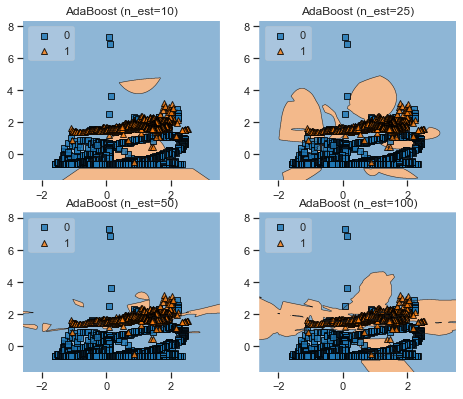

In [30]:
num_est = [10, 25, 50, 100]
label = ['AdaBoost (n_est=%d)' % i for i in num_est]

fig = plt.figure(figsize = (12, 10))
gs = gridspec.GridSpec(3, 3)
grid = itertools.product([0, 1], repeat = 2)

for n_est, label, grd in zip(num_est, label, grid):     
    boosting = AdaBoostClassifier(base_estimator = clf_weak, n_estimators = n_est)   
    boosting.fit(X[['Temperature', 'Light']], y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X = np.array(X[['Temperature', 'Light']]), y = np.array(y), clf = boosting, legend = 2)
    plt.title(label)

plt.show()

### Stacking

An ensemble learning technique that combines multiple classification or regression models via a meta-classifier or a meta-regressor. The base level models are trained based on complete training set then the meta-model is trained on the outputs of base level model as features. 

In the previous section, 7 algorithms have been implemented individually. Using the stacking method, it is possible to combine all the results from the 7 algorithms and produce an accurate result. However, this method may take a long time to run compared to the other two ensemble methods.

In [31]:
lr = LogisticRegression(multi_class = 'auto', solver = 'lbfgs')
sclf = StackingClassifier(
    classifiers = [clf1, clf2, clf3, clf4, clf5, clf6, clf7],
    meta_classifier = lr)

In [32]:
start = timer()
scores = cross_val_score(sclf, X, y, cv = 3, scoring = 'accuracy')
print('Accuracy: %.2f (+/- %.2f) [%s]' % (scores.mean(), scores.std(), 'Stacking Classifier'))
end = timer()
print("Time taken: ", round(end-start, 4), " second(s)")

Accuracy: 0.95 (+/- 0.04) [Stacking Classifier]
Time taken:  7.8179  second(s)


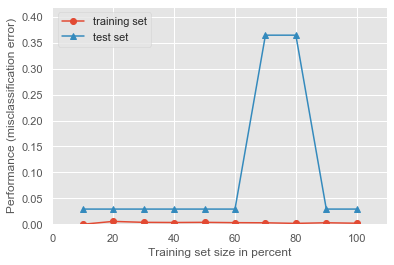

In [33]:
plt.figure()
plot_learning_curves(X, y, X_test, y_test, sclf, print_model = False, style = 'ggplot')
plt.show()

_______________________________________________________________________________________________________________

# Conclusion



The dataset can use Decision Tree to classify whether an area is occupied relatively more accurate. Ensemble models like bagging and boosting are able to give accurate results. However, selecting either one of the models depends on the time constraint, model requirement and minimum accuracy given. 

It is conclusive that Decision Tree classifier, Logistic Regression, SVM, Bagging models and Boosting models can produce an accurate prediction.

- Dummify Date time
    - Turn into day/night
- Business case
- Re-do the conclusion